In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import statsmodels as sm
import seaborn as sns; sns.set(style="white", color_codes=True)

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
sm.__version__

'0.11.0'

In [5]:
import fbprophet
from fbprophet import Prophet
fbprophet.__version__

'0.6'

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
tf.__version__

'2.2.0'

In [7]:
from ts_functions import smape, TSData
from minmax_scaling import MinMaxScaling

# Time Series Model Templates

A comparison of several time series models on a simple univariate dataset (the airline passengers data).

### Load data

In [8]:
ts = TSData.from_file("./data/AirPassengers.csv")

In [9]:
ts.data.head()

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


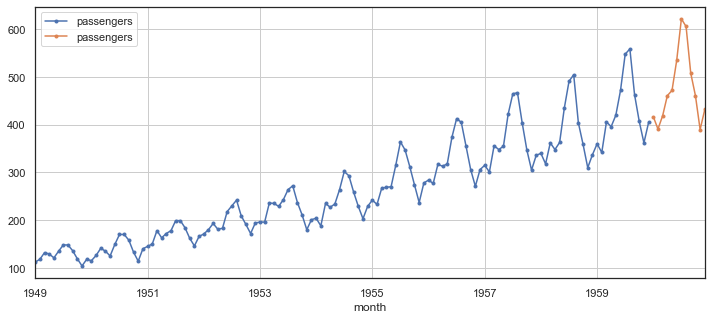

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ts.train_data.set_index("month").plot(marker='.', ax=ax, label="train");
ts.test_data.set_index("month").plot(marker='.', ax=ax, label="test");
plt.grid();

In [11]:
ts.set_column_names("ds", "y")

### Persistence model

Very simple model that we can use as a baseline. Takes the previous month for the prediction taking into account the seasonality.

In [12]:
forecast = ts.train_data["y"][-12:]
forecast.index = ts.test_data.index
forecast.name = "yhat"

In [13]:
df_test_p = ts.test_data.join(forecast)

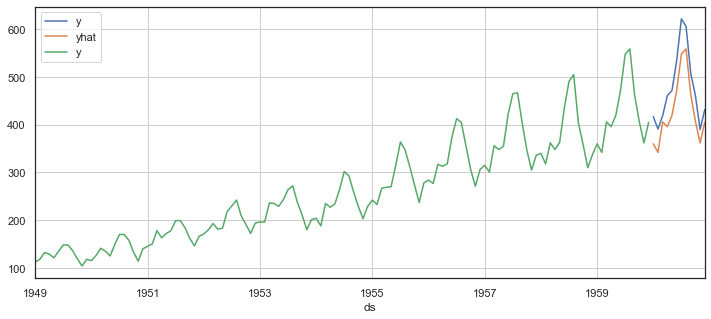

In [14]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [15]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 63.4308 %


### Min-max scaling model

A simple model which scales the previous period(s) by a scaling factor that is determined by the trend of the minimum and maximum in each period over time.

In [16]:
model_params = {
    "seasonality": 12,
    "lookback_periods": 6,
}

In [17]:
model = MinMaxScaling(**model_params)

In [18]:
ignore_years = 3   # do not fit to the first 3 years where the trend is non-linear
model.fit(ts.train_data["y"][12*ignore_years:])

In [19]:
forecast = pd.Series(model.forecast(1), name="yhat", index=ts.test_data.index)

In [20]:
df_test_p = ts.test_data.join(forecast)

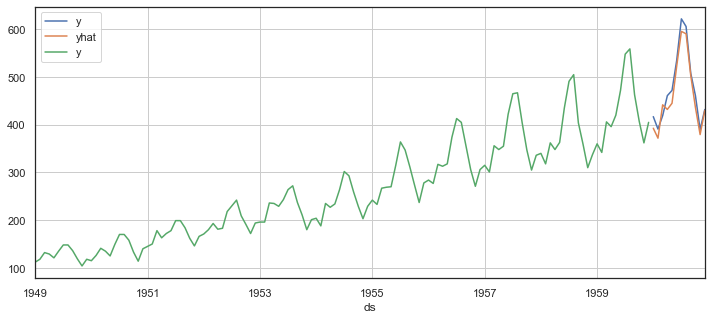

In [21]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [22]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 23.7092 %


### Prophet model

https://facebook.github.io/prophet/

In [23]:
model_params = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": 12,
    "seasonality_mode": "multiplicative",
    "interval_width": 0.95,
    "uncertainty_samples": 200,
}

In [24]:
model = Prophet(**model_params)

In [25]:
model.fit(ts.train_data)

In [26]:
future = model.make_future_dataframe(periods=12, freq="MS")
forecast = model.predict(future)

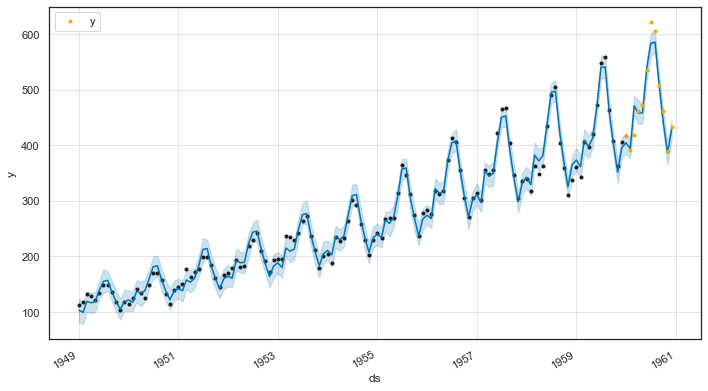

In [27]:
model.plot(forecast);
ts.test_data.set_index("ds").plot(c="orange", marker='.', linestyle="None", ax=plt.gca(), label="test");
plt.grid();

In [28]:
df_test_p = ts.test_data.merge(forecast.iloc[-12:][["ds", "yhat"]])

In [29]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 18.1770 %


### SARIMAX model

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [30]:
model_params = {
    "order": (1, 0, 0),
    "seasonal_order": (1, 0, 0, 12),
    "trend": 'ct'
}

In [31]:
model = SARIMAX(ts.train_data["y"], **model_params)

In [32]:
result = model.fit()
print(result.summary())

/Users/jeremysmith/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -507.031
Date:                            Wed, 17 Jun 2020   AIC                           1024.061
Time:                                    11:21:48   BIC                           1038.475
Sample:                                         0   HQIC                          1029.919
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4881      1.410      1.055      0.291      -1.276       4.252
drift          0.1044      0.031   

In [33]:
forecast = result.forecast(12)
forecast.name = "yhat"
predict = result.get_prediction().predicted_mean
predict.name = "yhat"
ci = result.get_prediction().conf_int(alpha=0.1)

In [34]:
df_test_p = ts.test_data.join(forecast)
df_train_p = ts.train_data.join(predict)

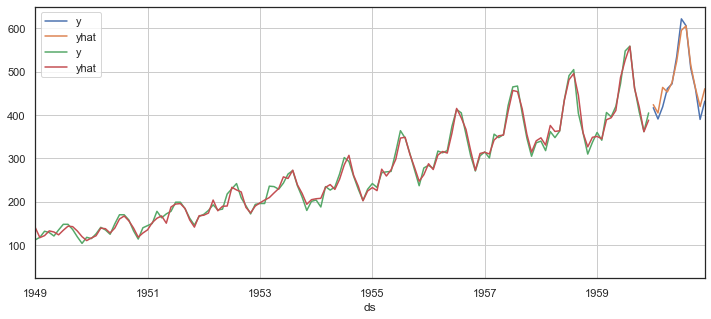

In [35]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
df_train_p.set_index("ds").plot(ax=ax)
ax.fill_between(df_train_p["ds"], ci["lower y"], ci["upper y"], alpha=0.35);
plt.grid();

In [36]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 19.7758 %


### Holt-Winters model

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [37]:
model_params = {
    "trend": "add",
    "damped": True,
    "seasonal": "mul",
    "seasonal_periods": 12,
}

In [38]:
model = ExponentialSmoothing(ts.train_data["y"], **model_params)

In [39]:
result = model.fit(use_boxcox=False)
print(result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                          13436.032
Optimized:                         True   AIC                            644.222
Trend:                         Additive   BIC                            693.230
Seasonal:                Multiplicative   AICC                           651.008
Seasonal Periods:                    12   Date:                 Wed, 17 Jun 2020
Box-Cox:                          False   Time:                         11:21:54
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3157921                alpha                 True
smoothing_slope          

In [40]:
forecast = result.forecast(12)
forecast.name = "yhat"
predict = result.fittedvalues
predict.name = "yhat"

In [41]:
df_test_p = ts.test_data.join(forecast)
df_train_p = ts.train_data.join(predict)

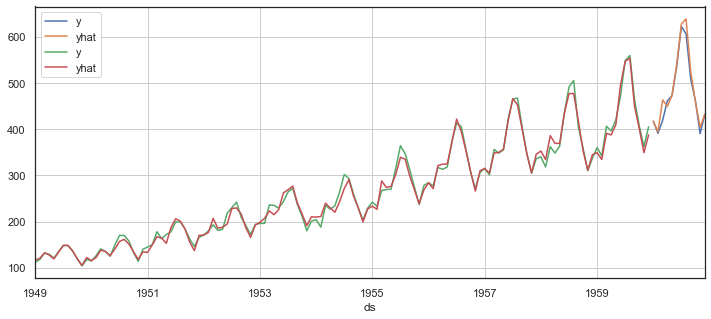

In [42]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
df_train_p.set_index("ds").plot(ax=ax)
plt.grid();

In [43]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 13.8358 %


### LSTM model

https://keras.io/api/layers/recurrent_layers/lstm/

Simple LSTM layer with FF layer to produce output series

In [44]:
# reload data for use in neural net models
ts_nn = TSData.from_file("./data/AirPassengers.csv")
ts_nn.set_column_names("ds", "y")

In [45]:
look_back = 3
look_fwd = 12

In [46]:
# perform differencing and rescaling
ts_nn.difference()
ts_nn.min_max_scale()

In [47]:
ts_nn.data.head()

,ds,y
0,1949-01-01,NaN
1,1949-02-01,0.569149
2,1949-03-01,0.611702
3,1949-04-01,0.521277
4,1949-05-01,0.494681


In [48]:
ts_nn.series_to_supervised(look_back, look_fwd)

In [49]:
ts_nn.data.head()

,ds,y(t-3),y(t-2),y(t-1),y(t+0),y(t+1),y(t+2),y(t+3),y(t+4),y(t+5),y(t+6),y(t+7),y(t+8),y(t+9),y(t+10),y(t+11)
4,1949-05-01,0.569149,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319
5,1949-06-01,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043
6,1949-07-01,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894
7,1949-08-01,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936
8,1949-09-01,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234


In [50]:
# reshape training data into [samples, timesteps, features]
X = ts_nn.train_data.filter(like="y").iloc[:, :look_back].values
X = X.reshape(X.shape[0], 1, X.shape[1])
y = ts_nn.train_data.filter(like="y").iloc[:, look_back:].values

In [51]:
model = Sequential()
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss="mean_squared_error", optimizer="adam")

In [52]:
# fit network reseting state between epochs
n_epoch = 200
for i in range(n_epoch):
    verbose = 1 if not i % 20 else 0
    model.fit(X, y, epochs=1, batch_size=1, verbose=verbose, shuffle=False)
    model.reset_states()

117/117 [==============================] - 0s 2ms/step - loss: 0.0047


In [53]:
X_test = ts_nn.test_data.filter(like="y").iloc[:, :look_back].values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [54]:
forecast = model.predict(X_test, batch_size=1)[-1]

In [55]:
# invert differencing and scaling and revert to TS data
forecast = ts_nn.inv_min_max_scale(forecast.reshape(-1, 1))
ts_nn.reset_data()
ts_nn.set_column_names("ds", "y")
forecast = ts_nn.inv_difference(forecast, [ts_nn.train_data["y"].iloc[-1]])[1:]

In [56]:
df_test_p = ts.test_data.join(pd.Series(forecast.reshape(-1), name="yhat", index=ts_nn.test_data.index))

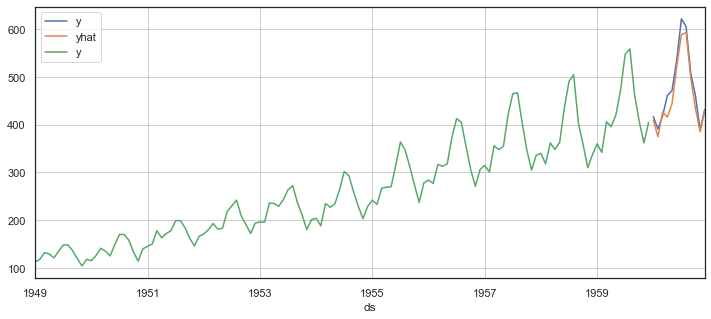

In [57]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [58]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 21.9805 %


### Windowed MPL model

In [59]:
look_back = 6
look_fwd = 12

In [60]:
# perform differencing and rescaling
ts_nn.difference()
ts_nn.min_max_scale()

In [61]:
ts_nn.series_to_supervised(look_back, look_fwd)

In [62]:
ts_nn.data.head()

,ds,y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t+0),y(t+1),y(t+2),y(t+3),y(t+4),y(t+5),y(t+6),y(t+7),y(t+8),y(t+9),y(t+10),y(t+11)
7,1949-08,0.569149,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936
8,1949-09,0.611702,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234
9,1949-10,0.521277,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404
10,1949-11,0.494681,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255
11,1949-12,0.611702,0.606383,0.537234,0.473404,0.446809,0.457447,0.611702,0.521277,0.595745,0.617021,0.505319,0.484043,0.664894,0.648936,0.537234,0.473404,0.404255,0.436170


In [63]:
# reshape training data
X = ts_nn.train_data.filter(like="y").iloc[:, :look_back].values
y = ts_nn.train_data.filter(like="y").iloc[:, look_back:].values

In [64]:
model = Sequential()
model.add(Dense(24, activation="relu", input_dim=look_back))
model.add(Dense(look_fwd))
model.compile(loss="mean_squared_error", optimizer="adam")

In [65]:
model.fit(X, y, epochs=1000, verbose=0)

In [66]:
X_test = ts_nn.test_data.filter(like="y").iloc[:, :look_back].values

In [67]:
forecast = model.predict(X_test)[-1]

In [68]:
# invert differencing and scaling and revert to TS data
forecast = ts_nn.inv_min_max_scale(forecast.reshape(-1, 1))
ts_nn.reset_data()
ts_nn.set_column_names("ds", "y")
forecast = ts_nn.inv_difference(forecast, [ts_nn.train_data["y"].iloc[-1]])[1:]

In [69]:
df_test_p = ts.test_data.join(pd.Series(forecast.reshape(-1), name="yhat", index=ts_nn.test_data.index))

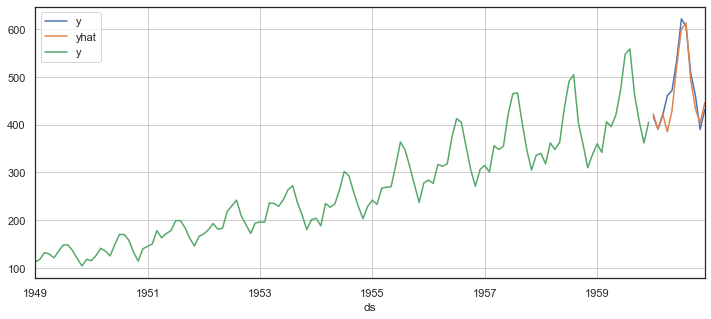

In [70]:
fig, ax = plt.subplots(1, figsize=(12, 5))
df_test_p.set_index("ds").plot(ax=ax)
ts.train_data.set_index("ds").plot(ax=ax)
plt.grid();

In [71]:
print("sMAPE on test set : {:.4f} %".format(smape(df_test_p["yhat"], df_test_p["y"])))

sMAPE on test set : 26.2429 %
